In [55]:
import os
import cv2
import json
import argparse
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

from utils.face_landmark import FaceAlignmentDetector
from utils.tool import draw_facial_landmarks
from utils.face_parsing import show_image

In [56]:
args_dict = {"json_file": './samples/meta_1-1.json'}

args = argparse.Namespace(**args_dict)

In [57]:
print(args)
# load json file
with open(args.json_file, 'r', encoding='utf8') as f:
    dtdict = json.load(f)

flmk_det = FaceAlignmentDetector()

save_folder = os.path.dirname(args.json_file)
head_image_folder = os.path.join(save_folder, 'head_images')
os.makedirs(head_image_folder, exist_ok=True)
head_parsing_folder = os.path.join(save_folder, 'head_parsing')
os.makedirs(head_parsing_folder, exist_ok=True)
align_image_folder = os.path.join(save_folder, 'align_images')
os.makedirs(align_image_folder, exist_ok=True)
align_parsing_folder = os.path.join(save_folder, 'align_parsing')
os.makedirs(align_parsing_folder, exist_ok=True)
print("head_image_folder:", head_image_folder)
print("head_parsing_folder:", head_parsing_folder)
print("align_image_folder:", align_image_folder)
print("align_parsing_folder:", align_parsing_folder)


Namespace(json_file='./samples/meta_1-1.json')


JSONDecodeError: Expecting value: line 408 column 21 (char 12099)

In [46]:
dtdict.keys()

dict_keys(['images/000679.png', 'images/000031.png', 'images/man.jpg', 'images/woman.jpg', 'images/000320.png'])

In [53]:
'''
Author: chence antonio.chan.cc@outlook.com
Date: 2023-09-19 16:50:42
LastEditors: chence antonio.chan.cc@outlook.com
LastEditTime: 2023-09-19 22:56:35
FilePath: /DatProc/02.front_view.ipynb
Description: 这是默认设置,请设置`customMade`, 打开koroFileHeader查看配置 进行设置: https://github.com/OBKoro1/koro1FileHeader/wiki/%E9%85%8D%E7%BD%AE
'''
from utils.recrop_images import FrontViewRecropper
from utils.face_parsing import HeadParser, show_result
from utils.fv_utils import rotate_image, generate_results, crop_head_image, crop_head_parsing
import utils.tool as mtool
import importlib
importlib.reload(mtool)
draw_quad = mtool.draw_quad
R2hpose = mtool.R2hpose

# TODO Write validate code to eval transmatrix
# TODO refine front view pipeline

recropper = FrontViewRecropper()
hpar = HeadParser()
head_image_size = 1024

# inverse convert from OpenCV camera
convert = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, -1],
]).astype(np.float32)
inv_convert = np.linalg.inv(convert)

for dtkey, dtitem in tqdm(dtdict.items()):
    if dtkey != 'images/000320.png': continue
    image_path = os.path.join(save_folder, dtitem['raw']['file_path'])
    image_name = os.path.basename(image_path)[:-4]
    image_data = cv2.imread(image_path)
    head_boxes = dtitem['raw']['head_boxes']
    dtdict[dtkey]['raw']['landmarks'] = {}
    dtdict[dtkey]['raw']['raw_quad'] = {}
    dtdict[dtkey]['raw']['tgt_quad'] = {}
    dtdict[dtkey]['raw']['rot_quad'] = {}
    dtdict[dtkey]['raw']['q2b_tf'] = {}
    dtdict[dtkey]['raw']['rotmat'] = {}
    dtdict[dtkey]['raw']['head_boxes_resize'] = head_image_size
    dtdict[dtkey]['head'] = {}
    for box_id, box in head_boxes.items():
        dtdict[dtkey]['head'][box_id] = {}
        box_np = np.array(box)
        head_image = crop_head_image(image_data.copy(), box_np)
        assert head_image.shape[0] == head_image.shape[1]
        landmarks = flmk_det(head_image, True, box_np[:2])
        if landmarks is not None:
            assert np.sum(landmarks < 0) == 0
            dtdict[dtkey]['raw']['landmarks'][box_id] = landmarks.tolist()

            cropped_img, camera_poses, quad, tf_quad = recropper(image_data.copy(), landmarks)
            quad, tf_quad = np.array(quad), np.array(tf_quad)
            dtdict[dtkey]['head'][box_id]['camera'] = camera_poses.tolist()
            dtdict[dtkey]['raw']['raw_quad'][box_id] = quad.tolist()
            dtdict[dtkey]['raw']['tgt_quad'][box_id] = tf_quad.tolist()

            # cam2world
            c2wR = camera_poses[:16].reshape(4, 4)[:3, :3]
            w2cR = inv_convert @ c2wR
            hpose = R2hpose(w2cR)
            dtdict[dtkey]['head'][box_id]['hpose'] = hpose # yaw, roll, pitch

            quad_w = np.linalg.norm(quad[2] - quad[1])
            quad_h = np.linalg.norm(quad[1] - quad[0])
            quad_center = np.mean(quad, axis=0)
            hbox_w = box_np[2]
            hbox_h = box_np[3]
            hbox_center = box_np[:2] + box_np[2:] / 2.
            dtdict[dtkey]['raw']['q2b_tf'][box_id] = {
                'scale': [quad_w / hbox_w, quad_h / hbox_h],
                'shift': [(quad_center[0] - hbox_center[0]) / hbox_w, (quad_center[1] - hbox_center[1]) / hbox_h]
            }

            rotated_image, rotmat, rot_quad = rotate_image(image_data.copy(), quad, tf_quad, borderMode=cv2.BORDER_REFLECT, upsample=2)
            dtdict[dtkey]['raw']['rotmat'][box_id] = rotmat.tolist()
            dtdict[dtkey]['raw']['rot_quad'][box_id] = rot_quad.tolist()

            head_image, head_crop_box, head_rot_quad = generate_results(rotated_image, rot_quad, box_np, head_image_size)
            dtdict[dtkey]['head'][box_id]['align_box'] = head_crop_box.tolist() # [x1, y1, w, h]
            dtdict[dtkey]['head'][box_id]['align_quad'] = head_rot_quad.tolist() # [tl, bl, br, tr]

            # head_parsing = hpar(head_image, is_bgr=True, show=True)
            head_parsing = hpar(head_image, is_bgr=True, show=False)
            cropped_par = crop_head_parsing(head_parsing.copy(), head_crop_box)
            cropped_par = cv2.resize(cropped_par, (cropped_img.shape[1], cropped_img.shape[0]), interpolation=cv2.INTER_NEAREST)

            head_image_path = os.path.join(head_image_folder, f"{image_name}_{box_id}.png")
            cv2.imwrite(head_image_path, head_image)
            head_parsing_path = os.path.join(head_parsing_folder, f"{image_name}_{box_id}.png")
            cv2.imwrite(head_parsing_path, head_parsing)

            align_image_path = os.path.join(align_image_folder, f"{image_name}_{box_id}.png")
            cv2.imwrite(align_image_path, cropped_img)
            align_parsing_path = os.path.join(align_parsing_folder, f"{image_name}_{box_id}.png")
            cv2.imwrite(align_parsing_path, cropped_par)

            # show_result(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB), cropped_par, hpar.label)

            # vis = draw_facial_landmarks(image_data.copy(), landmarks.astype(np.int32))
            # vis = draw_quad(vis, quad.astype(np.int32))
            # show_image(vis, is_bgr=True, title=dtkey, show_axis=True)

            # show_image(cropped_img, is_bgr=True, title=dtkey, show_axis=True)
            # head_crop_image = crop_head_image(head_image.copy(), head_crop_box)
            # show_image(head_crop_image, is_bgr=True, title=dtkey, show_axis=True)
            # show_image(cropped_img, is_bgr=True, title=dtkey, show_axis=True)
            # cropped_img_3 = cv2.resize(head_crop_image, (cropped_img.shape[1], cropped_img.shape[0]))
            # show_image(cropped_img_3, is_bgr=True, title=dtkey, show_axis=True)
            # delta_cropped_img = np.abs(cropped_img_3 - cropped_img)
            # print(np.sum(delta_cropped_img), np.mean(delta_cropped_img), np.max(delta_cropped_img), np.min(delta_cropped_img))
            # show_image(delta_cropped_img, is_bgr=True, title=dtkey, show_axis=True)
            # print(head_crop_image.shape, head_image.shape)
            # print(1024 * head_crop_image.shape[0] / head_image.shape[0])
        break
    break

 80%|████████  | 4/5 [00:01<00:00,  3.87it/s]


In [29]:
with open(args.json_file, 'w', encoding='utf8') as f:
    json.dump(dtdict, f, indent=4)

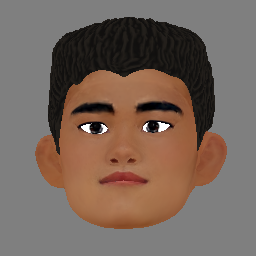

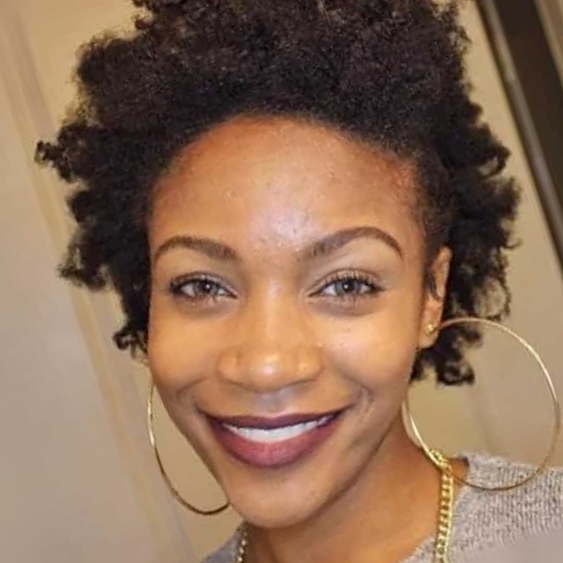

In [54]:








from PIL import Image

display(Image.fromarray(R_img))
display(Image.fromarray(cropped_img[:, :, ::-1]))

In [42]:
camera_poses[:16].reshape(4, 4)[:3, :3]

array([[ 0.96788794, -0.03293897,  0.2470123 ],
       [ 0.01565804, -0.9662056 , -0.25630832],
       [ 0.25149912,  0.25625303, -0.934663  ]])